# 0.データ読み込み

全解析で共通のデータフレームをここで読み込む。  
このDFを基本とし各解析ごとに不要な列の削除やdropを行うが、そのDropは次の解析には持ち越さず。毎回やり直す。

異常値の処理についても、上記の対応に同じ。各解析の中で異常値の行を落としても、他の解析で同行の異なる列のデータを利用する場合もあるので、全体には影響させないようにする。

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression



In [3]:
gpd_data = gpd.read_file('/workspaces/akita_daizu/data/474+120圃場.geojson')
soil_data = pd.read_excel('/workspaces/akita_daizu/data/0208修正_土壌データ+収量.xlsx', header=0)

UniquIDがふってある120圃場の解析だけで良いので、読み込んだ2ファイルを120圃場ののIDをKeyに接続する

In [4]:
# gpdの結合用うの行の削除と作成
gpd_data['作付け開始年'] = ''
gpd_data['圃場番号'] = gpd_data['uniqueID']
gpd_data['排水性の良否'] = gpd_data['pred_labels']
gpd_data['EVI20902mean'] = gpd_data['EVI2mean']

# gpdの必要な行だけ抽出して結合する ほしい行は以下の4行
selected_gpd = gpd_data[['圃場番号','排水性の良否','作付年_y', 'H23以前_y','播種月日','作付け開始年','EVI20902mean','EVI20903mean','geometry']]


In [5]:
#　この作付け年とH23以前を一つの列に。　まず作付け年が空ならH23以前を入れ込むようにFor
for index, row in selected_gpd[['作付年_y', 'H23以前_y','作付け開始年']].iterrows():
    if row['H23以前_y'] is not None :
        selected_gpd['作付け開始年'][index] =row['H23以前_y']
    elif  row['作付年_y'] is not None :
        selected_gpd['作付け開始年'][index] = row['作付年_y']

# それぞれの和暦を西暦に変更
# H23 2011 H24 2012 H25 2013 R1 2019
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ3～',r'2021',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ2～',r'2020',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｒ1～',r'2019',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ30～',r'2017',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ28～',r'2016',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ27～',r'2015',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ26～',r'2014',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ25～',r'2013',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'Ｈ24～',r'2012',)
selected_gpd['作付け開始年'] = selected_gpd['作付け開始年'].str.replace(r'☑',r'2011',)
selected_gpd['作付け開始年'].unique()

target_selected_gpd = selected_gpd

/tmp/ipykernel_37320/436268765.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_gpd['作付け開始年'][index] =row['H23以前_y']
/tmp/ipykernel_37320/436268765.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_gpd['作付け開始年'][index] = row['作付年_y']
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(Ge

In [6]:
#まず　GPDとSOILデータでuniqueIDをキーにして全部結合する
merged_pd = pd.merge(soil_data, target_selected_gpd, on=['圃場番号'], how='inner')

In [7]:
# heatmap作成のため不要な行の削除 土壌硬度周り
drop_columns = merged_pd.filter(like='土壌硬度', axis=1).columns.values
droped_soil_data = merged_pd.drop(drop_columns, axis = 1)

In [8]:
# heatmap作成のため不要な行の削除
drop_columns = ['播種月日_x','生育状況','最大圧の深さの平均', '最大圧力の平均','調査日', '作付年_y', 'H23以前_y','現物重量ｋｇ', '計量時水分％', '圃場面積', '住所', '反収現物重量kg/10a',
       '15%時の重量','geometry']
second_droped_soil_data = droped_soil_data.drop(drop_columns, axis = 1)

In [9]:
# 作付け開始年はこれでint化　播種日はエクセルで日付けにしといてDateTime化
second_droped_soil_data['作付け開始年'] = second_droped_soil_data['作付け開始年'].map(lambda x: int(x))
second_droped_soil_data['播種月日_y'] = pd.to_datetime(second_droped_soil_data['播種月日_y'])

# DateTimeで評価しようと思ったけど、播種日datatime形式だとheatmap作成時に読み込まれない？ intにする
int_time = second_droped_soil_data['播種月日_y'].map(pd.Timestamp.timestamp).astype(int)
# Formatの調整
int_time = second_droped_soil_data['播種月日_y'].dt.strftime('%m%d')
int2_time = int_time.str.lstrip('0').astype(int)
second_droped_soil_data['播種月日'] = int2_time
# フォーマット直した播種日入力したから古いの削除
second_droped_soil_data = second_droped_soil_data.drop(['播種月日_y'], axis = 1)

In [10]:
# これで収量が入っている行には必ず作付け開始年も入力される = 終了の列以外にnullは存在しない
print(second_droped_soil_data.isnull().sum())

圃場番号                    0
現場測定_EC(㎳／㎝)            0
現場測定_PH                 0
SoilName                0
15%反収現物重量kg/10a        82
実験室測定_EC(㎳／㎝)           0
実験室測定_pH                0
アンモニア態窒素(mgN/100g)      0
硝酸態窒素(mgN/100g)         0
可給隊窒素(mgN/100g)         0
有効態リン酸(mgP2O5/100g)     0
TC(%)                   0
腐食(%)                   0
TN(%)                   0
排水性の良否                  0
作付け開始年                  0
EVI20902mean            0
EVI20903mean            0
播種月日                    0
dtype: int64


In [11]:
# soil nameをラベルエンコードする
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(second_droped_soil_data["SoilName"].values)

#データ変換
second_droped_soil_data["土壌_CD"] = LE.fit_transform(second_droped_soil_data["SoilName"].values)
print(second_droped_soil_data["土壌_CD"].unique())
print(second_droped_soil_data["SoilName"].unique())

[1 2 0]
['典型普通砂質未熟土' '淡色普通非アロフェン質黒ボク土' 'グライ低地土']


# 1.収量と各パラメータの相関分析

## 1-1 全体の相関について

In [12]:
# ex ph 共に異常値を取り除く
soil_data_wo_error = second_droped_soil_data.drop(second_droped_soil_data[second_droped_soil_data['現場測定_EC(㎳／㎝)']>100].index)
# 表示順序変える
# soil_data_wo_error.columns
soil_data_wo_error_sort = soil_data_wo_error[['15%反収現物重量kg/10a', '現場測定_EC(㎳／㎝)', '現場測定_PH', '実験室測定_EC(㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)','播種月日',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', '腐食(%)', 'TN(%)','作付け開始年','土壌_CD','EVI20902mean','EVI20903mean']]

In [12]:
soil_data_wo_error_sort['EVI2_Ave'] = soil_data_wo_error_sort['EVI20902mean'] + soil_data_wo_error_sort['EVI20903mean']
soil_data_wo_error_sort['EVI2_Ave'] = soil_data_wo_error_sort['EVI2_Ave']/2

/tmp/ipykernel_29328/2229095787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soil_data_wo_error_sort['EVI2_Ave'] = soil_data_wo_error_sort['EVI20902mean'] + soil_data_wo_error_sort['EVI20903mean']
/tmp/ipykernel_29328/2229095787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soil_data_wo_error_sort['EVI2_Ave'] = soil_data_wo_error_sort['EVI2_Ave']/2


In [13]:
soil_data_wo_error_sort = soil_data_wo_error[['15%反収現物重量kg/10a', '現場測定_EC(㎳／㎝)', '現場測定_PH', '実験室測定_EC(㎳／㎝)',
       '実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', '腐食(%)', 'TN(%)','作付け開始年','土壌_CD','EVI20902mean','EVI20903mean']]

In [14]:
corr = soil_data_wo_error_sort.corr()
corr

,15%反収現物重量kg/10a,現場測定_EC(㎳／㎝),現場測定_PH,実験室測定_EC(㎳／㎝),実験室測定_pH,アンモニア態窒素(mgN/100g),硝酸態窒素(mgN/100g),可給隊窒素(mgN/100g),有効態リン酸(mgP2O5/100g),TC(%),腐食(%),TN(%),作付け開始年,土壌_CD,EVI20902mean,EVI20903mean
15%反収現物重量kg/10a,1.000000,-0.098741,0.382815,0.079567,0.272177,0.110913,0.085855,-0.267269,0.025712,-0.346953,-0.346927,-0.351237,-0.338823,-0.325983,0.615086,0.551441
現場測定_EC(㎳／㎝),-0.098741,1.000000,-0.225461,0.387589,-0.160535,0.133778,0.464669,0.338044,0.459276,0.190283,0.190155,0.289789,0.015926,0.132218,0.225840,0.186735
現場測定_PH,0.382815,-0.225461,1.000000,-0.479375,0.891794,-0.029096,-0.306085,-0.477879,-0.125963,-0.612091,-0.612004,-0.643334,-0.209740,-0.325014,-0.049145,-0.079995
実験室測定_EC(㎳／㎝),0.079567,0.387589,-0.479375,1.000000,-0.610514,0.137729,0.509986,0.371662,0.285580,0.549516,0.549621,0.619225,-0.054203,0.200652,0.312503,0.304580
実験室測定_pH,0.272177,-0.160535,0.891794,-0.610514,1.000000,-0.070237,-0.360150,-0.460103,-0.107966,-0.671240,-0.671136,-0.702744,-0.130100,-0.389735,0.006891,-0.024993
アンモニア態窒素(mgN/100g),0.110913,0.133778,-0.029096,0.137729,-0.070237,1.000000,0.278097,-0.172677,0.076951,0.054065,0.054106,0.106961,-0.066100,0.157828,0.069286,0.067650
硝酸態窒素(mgN/100g),0.085855,0.464669,-0.306085,0.509986,-0.360150,0.278097,1.000000,0.029125,0.367087,0.466896,0.466755,0.532750,-0.018964,0.232187,0.128263,0.094267
可給隊窒素(mgN/100g),-0.267269,0.338044,-0.477879,0.371662,-0.460103,-0.172677,0.029125,1.000000,0.225183,0.380799,0.380646,0.412391,0.280800,0.145265,0.182332,0.178542
有効態リン酸(mgP2O5/100g),0.025712,0.459276,-0.125963,0.285580,-0.107966,0.076951,0.367087,0.225183,1.000000,0.364534,0.364781,0.384228,-0.033787,0.115318,0.206456,0.169463
TC(%),-0.346953,0.190283,-0.612091,0.549516,-0.671240,0.054065,0.466896,0.380799,0.364534,1.000000,0.999999,0.975090,0.010441,0.392580,0.104157,0.154910


<AxesSubplot:>

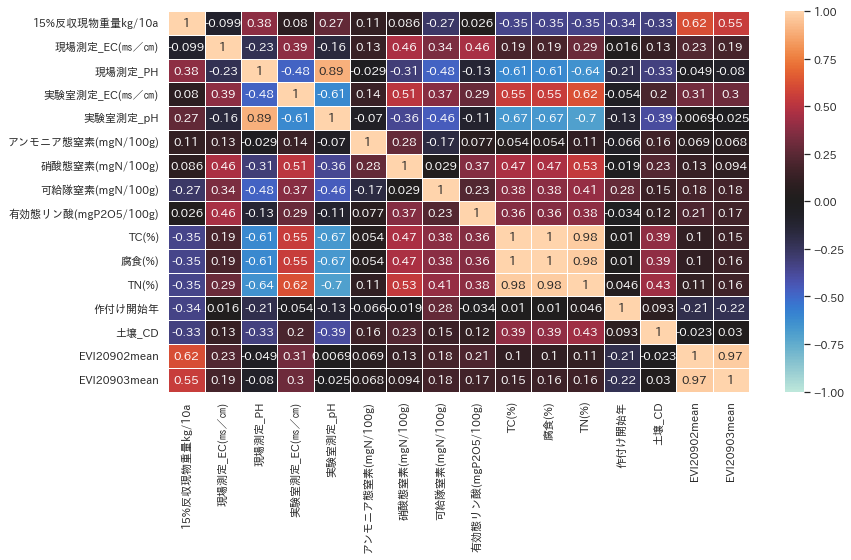

In [15]:
# sns　setするとフォントもデフォルトのsans serifになって文字化けするから、Plotサイズ変える時にフォントも指定する
sns.set(rc = {'figure.figsize':(13,7)},font='IPAexGothic')
sns.heatmap(corr,annot=True, vmax=1, vmin=-1, center=0,linewidths=.5)

## 1-2重回帰

### 1-2-1　参考　Sklearnの全回帰モデル + LGBMRegressor + XGBoost ざっくりモデル比較

In [30]:
soil_data_only_yield= second_droped_soil_data.dropna()
data_only_yield_soil_vwc = soil_data_only_yield[['実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', 'TN(%)', "排水性の良否",'土壌_CD','15%反収現物重量kg/10a']]
X = data_only_yield_soil_vwc.iloc[:,:-1]  
Y = data_only_yield_soil_vwc.iloc[:,-1] 

In [32]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from lightgbm import LGBMRegressor
import xgboost as xgb

reg_dict = {"LinearRegression": LinearRegression(),
            "xgboost": xgb.XGBRegressor(),
            "Lightgbm": LGBMRegressor(),
            "Ridge": Ridge(),
            "Lasso": Lasso(),
            "ElasticNet": ElasticNet(), 
            # "Polynomial_deg2": Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression())]),
            "Polynomial_deg3": Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression())]),
            # "Polynomial_deg4": Pipeline([('poly', PolynomialFeatures(degree=4)),('linear', LinearRegression())]),
            # "Polynomial_deg5": Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression())]),
            "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=3),
            # "DecisionTreeRegressor": DecisionTreeRegressor(),
            "RandomForestRegressor": RandomForestRegressor(),
            "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=0.1),
            "GaussianProcessRegressor": GaussianProcessRegressor(),
            "SGDRegressor": SGDRegressor(),
            "MLPRegressor": MLPRegressor(hidden_layer_sizes=(10,10), max_iter=100, early_stopping=True, n_iter_no_change=5),
            "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100), 
            # "PLSRegression": PLSRegression(n_components=10),
            "PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=100, tol=1e-3),
            "TheilSenRegressor": TheilSenRegressor(random_state=0),
            "RANSACRegressor": RANSACRegressor(random_state=0),
            "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
            "AdaBoostRegressor": AdaBoostRegressor(random_state=0, n_estimators=100),
            "BaggingRegressor": BaggingRegressor(base_estimator=SVR(), n_estimators=10),
            "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
            "VotingRegressor": VotingRegressor([('lr', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=10))]),
            "StackingRegressor": StackingRegressor(estimators=[('lr', RidgeCV()), ('svr', LinearSVR())], final_estimator=RandomForestRegressor(n_estimators=10)),
            "ARDRegression": ARDRegression(),
            "HuberRegressor": HuberRegressor(),
                    }

In [ ]:
from sklearn.model_selection import train_test_split
import random
from sklearn.datasets import make_regression
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    """MAPE"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_size = 0.3  # 分割比率
N_trials = 10  # 試行回数

# 回帰対象のデータを生成

mape_dict = {reg_name:[] for reg_name in reg_dict.keys()}  # 精度の格納庫

for i in range(N_trials):
    print(f"Trial {i+1}")
    random_state = 42
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    for reg_name, reg in reg_dict.items():
        reg.fit(x_train,y_train)
        y_pred = reg.predict(x_test)
        mape = mean_absolute_percentage_error(y_test, y_pred)  # MAPEを算出
        mape_dict[reg_name].append(mape)  # 格納

# MAPEの平均値でソート
mape_dict_sorted = {key: value for key, value in reversed(sorted(mape_dict.items(), key=lambda x:np.mean(x[1])))}

〜〜〜MAPEは、主に時系列予測や回帰問題における出力層の評価関数としても用いられる。例えば一般のビジネスマンに向けて誤差をパーセント（確率値）で分かりやすく伝えたいときなどで役立つだろう。0に近いほどより良い。なお、数値そのものではなくパーセントという比率を評価する関数であるので、最適化を行うための損失関数としては基本的に使われない。
〜〜〜
https://atmarkit.itmedia.co.jp/ait/articles/2106/09/news028.html

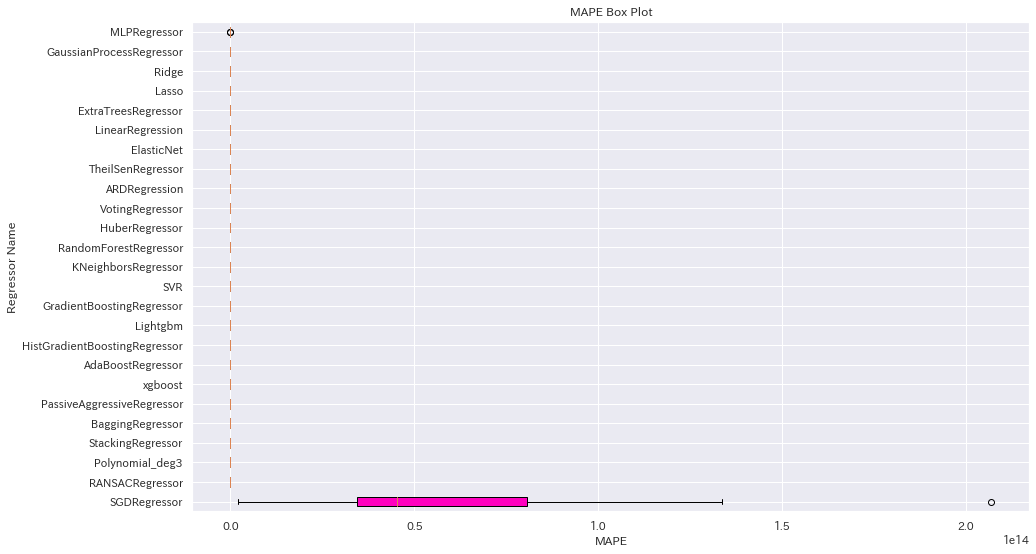

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

plt.rcParams["font.size"] = 18  # フォントサイズを大きくする
scalarMap = cm.ScalarMappable(norm=Normalize(vmin=0, vmax=len(mape_dict)), cmap=plt.get_cmap('gist_rainbow_r'))

plt.figure(figsize=(15,9))
box=plt.boxplot(mape_dict_sorted.values(), vert=False, patch_artist=True,labels=mape_dict_sorted.keys())
for i, patch in enumerate(box['boxes']):
    patch.set_facecolor(scalarMap.to_rgba(i))
plt.title("MAPE Box Plot")
plt.xlabel("MAPE")
plt.ylabel("Regressor Name")
plt.show()

* ?　パラメータちゃんとチューンしてないlgbmやxgboostは良い結果が出ない？　
* リッジかラッソで考える
* SGDはSKlearnのフローで10万件以上のデータがあるときに使うそう

※ Oputunaを組み込んだ場合の表かはまた別の機会に考える

* OLS：コスト関数の最小化問題
* リッジ回帰：L2正則化項を追加　過学習の防止
* ラッソ回帰：L1正則化項を追加　不要なパラメータの削除

### 1-2-2　複数の回帰モデルのパイプラインによる解析・評価

標準化を含むパイプラインと含まない場合の、複数のモデルでの解析と評価

In [21]:
soil_data_only_yield= second_droped_soil_data.dropna()
data_only_yield_soil_vwc = soil_data_only_yield[['実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', 'TN(%)', "排水性の良否",'土壌_CD','15%反収現物重量kg/10a']]
X = data_only_yield_soil_vwc.iloc[:,:-1]  
Y = data_only_yield_soil_vwc.iloc[:,-1] 

In [22]:
# 標準化あり
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# holdout
X_train,X_test,y_train,y_test=train_test_split(X,
                                               Y,
                                               test_size=0.3,
                                               random_state=1)
# set pipelines for different algorithms
pipelines = {
    'LinearRegression':
        Pipeline([('scl',StandardScaler()),
                  ('est',LinearRegression())]),
    'Lasso':
        Pipeline([('scl',StandardScaler()),
                  ('est',Lasso())]),
    'Ridge':
        Pipeline([('scl',StandardScaler()),
                  ('est',Ridge())]),

}
# fit & evaluation
from sklearn.metrics import r2_score
scl_scores = {}
for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    scl_scores[(pipe_name,'scl_train')] = r2_score(y_train, pipeline.predict(X_train))
    scl_scores[(pipe_name,'scl_test')] = r2_score(y_test, pipeline.predict(X_test))

In [23]:
# 標準化なし
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# holdout
X_train,X_test,y_train,y_test=train_test_split(X,
                                               Y,
                                               test_size=0.3,
                                               random_state=1)
# set pipelines for different algorithms
pipelines = {
    'LinearRegression':
        Pipeline([('est',LinearRegression())]),
    'Lasso':
        Pipeline([('est',Lasso())]),
    'Ridge':
        Pipeline([('est',Ridge())]),

}
# fit & evaluation
from sklearn.metrics import r2_score
scores = {}
for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    scores[(pipe_name,'train')] = r2_score(y_train, pipeline.predict(X_train))
    scores[(pipe_name,'test')] = r2_score(y_test, pipeline.predict(X_test))

In [24]:
scl_scores_df = pd.Series(scl_scores).unstack()
scores_df = pd.Series(scores).unstack()
pd.concat([scl_scores_df, scores_df], axis=1)

,scl_test,scl_train,test,train
Lasso,-1.152057,0.651463,-0.990779,0.563139
LinearRegression,-2.137727,0.727155,-2.137727,0.727155
Ridge,-0.898044,0.636182,-0.728659,0.560360


標準化してもしなくても同じ精度？　若干標準化した方が高いかも

### 1-2-2　重回帰分析 レポーティング用 任意の重回帰を評価

このデータだとラッソもリッジもOLSも大差なし。モデルこねくり回さずにさっさとまとめる。

In [25]:
data_only_yield_soil_vwc.iloc[:,-1] 

0      130.0
4      138.0
7      251.0
8      162.0
10     164.0
26     157.0
28     165.0
32     205.0
37      34.0
42     101.0
47      18.0
50     110.0
51      39.0
53      88.0
54     139.0
56      76.0
58     159.0
59      14.0
63      92.0
69     141.0
72     155.0
74     168.0
77     132.0
86     111.0
91     131.0
94     166.0
95     188.0
98     195.0
101    179.0
104    181.0
106    184.0
Name: 15%反収現物重量kg/10a, dtype: float64

In [26]:
soil_data_only_yield= second_droped_soil_data.dropna()
data_only_yield_soil_vwc = soil_data_only_yield[['実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)', '硝酸態窒素(mgN/100g)',
       '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TC(%)', 'TN(%)', "排水性の良否",'土壌_CD','15%反収現物重量kg/10a']]
X = data_only_yield_soil_vwc.iloc[:,:-1]  
Y = data_only_yield_soil_vwc.iloc[:,-1] 

In [27]:
X

,実験室測定_EC(㎳／㎝),実験室測定_pH,アンモニア態窒素(mgN/100g),硝酸態窒素(mgN/100g),可給隊窒素(mgN/100g),有効態リン酸(mgP2O5/100g),TC(%),TN(%),排水性の良否,土壌_CD
0,41.2,7.26,1.53,0.62,4.40,37.0,1.00,0.106,1,1
4,41.8,7.03,1.20,0.32,4.76,80.7,0.82,0.085,3,1
7,33.7,7.06,1.82,0.06,3.01,32.0,0.44,0.047,3,1
8,31.0,7.16,1.36,0.62,3.17,34.0,0.80,0.079,3,1
10,36.2,6.98,1.82,0.23,4.04,67.4,0.93,0.076,3,1
26,47.0,6.13,3.17,1.70,4.52,185.2,3.91,0.294,1,2
28,54.3,6.71,2.25,2.23,2.71,306.0,3.12,0.263,3,2
32,60.7,6.43,2.57,1.13,4.74,63.4,2.80,0.242,2,2
37,40.3,6.45,1.83,0.66,4.50,92.0,4.85,0.315,4,2
42,45.8,6.18,2.06,1.26,4.90,106.5,5.77,0.359,2,2


In [28]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


def sklearn_calc(labels, params):
    # トレーニングデータとテストデータに分割
    x_train, x_test, y_train, y_test = train_test_split(
    params, labels.ravel(), test_size=0.2)

    # Lasso
    LassoModel = Lasso(alpha=1.0, random_state=0)
    LassoModel.fit(x_train, y_train)

    # Rideg
    RidgeModel = Ridge(alpha=1.0, random_state=0)
    RidgeModel.fit(x_train, y_train)

    # LinReg
    LinRegModel = LinearRegression()
    LinRegModel.fit(x_train, y_train)

    scoring = {"p": "precision_macro",
            "r": "recall_macro",
            "f":"f1_macro"}

    # 各モデルによる回帰の評価(決定係数の表示)
    print("R-squared_Lasso : ", LassoModel.score(x_test, y_test))
    print("R-squared_Ridge : ", RidgeModel.score(x_test, y_test))
    print("R-squared_LinReg : ", LinRegModel.score(x_test, y_test))

    # データセットをランダムに5分割するための変数cvを定義
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    print('###################################################')
    scores = cross_validate(LassoModel, x_train, y_train, cv=cv, scoring=scoring)
    print(scores)
    print('###################################################')
    scores = cross_validate(RidgeModel, x_train, y_train, cv=cv, scoring=scoring)
    print(scores)
    print('###################################################')
    scores = cross_validate(LinRegModel, x_train, y_train, cv=cv, scoring=scoring)
    print(scores)
    # print("R-squared_Average_LinReg　: {0:.2f}".format(scores.mean()))

    # matplotでグラフ化
    min_label = labels.ravel().min()
    max_label = labels.ravel().max()
    Lasso_predicted = LassoModel.predict(params)
    Ridge_predicted = RidgeModel.predict(params)
    LinReg_predicted = LinRegModel.predict(params)

    fig, ax = plt.subplots(figsize=(9,7))
    ax.scatter(labels.ravel(), Lasso_predicted, edgecolors=(0, 0, 0),label='ラッソ回帰')
    ax.scatter(labels.ravel(), Ridge_predicted, edgecolors=(0, 0, 0),label='リッジ回帰')
    ax.scatter(labels.ravel(), LinReg_predicted, edgecolors=(0, 0, 0),label='線形回帰')
    ax.plot([min_label, max_label],
            [min_label, max_label], 'k--', lw=4)
    ax.legend()
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    return

R-squared_Lasso :  0.17539714190864186
R-squared_Ridge :  0.1476465406964097
R-squared_LinReg :  0.2882041439436246
###################################################
{'fit_time': array([0.00207472, 0.0034368 , 0.00154209, 0.00117826, 0.00662708]), 'score_time': array([0.00255036, 0.00216436, 0.00117755, 0.00176072, 0.00087571]), 'test_p': array([nan, nan, nan, nan, nan]), 'test_r': array([nan, nan, nan, nan, nan]), 'test_f': array([nan, nan, nan, nan, nan])}
###################################################
{'fit_time': array([0.00130606, 0.00076556, 0.00091004, 0.00106382, 0.00156903]), 'score_time': array([0.00104022, 0.00085044, 0.00082159, 0.00119758, 0.00094271]), 'test_p': array([nan, nan, nan, nan, nan]), 'test_r': array([nan, nan, nan, nan, nan]), 'test_f': array([nan, nan, nan, nan, nan])}
###################################################
{'fit_time': array([0.00249076, 0.00130582, 0.00086093, 0.00077915, 0.00110912]), 'score_time': array([0.00182939, 0.0011394 , 0.00082

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1757, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1544, in precision_re

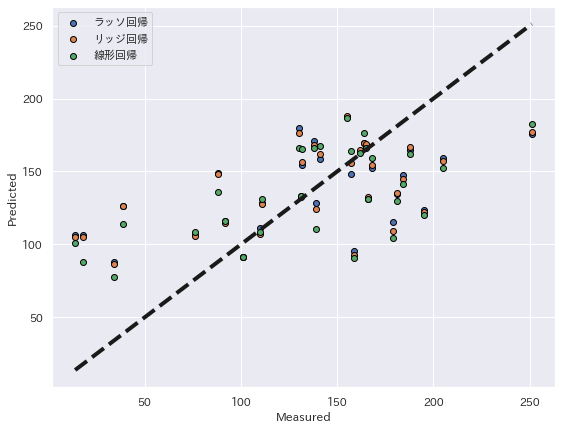

In [29]:
sklearn_calc(Y,X)

StasModelの分析

↓Statsmodelは線形回帰モデルの引数のL1_wtに"0"を与えたらRidge回帰"1"を与えたらLasso回帰
https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html

In [18]:
soil_data_only_yield= second_droped_soil_data.dropna()
data_only_yield_soil_vwc = soil_data_only_yield[[
    '実験室測定_EC(㎳／㎝)','実験室測定_pH', 'アンモニア態窒素(mgN/100g)',
    #  '硝酸態窒素(mgN/100g)',
    '可給隊窒素(mgN/100g)', '有効態リン酸(mgP2O5/100g)', 'TN(%)','土壌_CD','15%反収現物重量kg/10a'
    ]]
X = data_only_yield_soil_vwc.iloc[:,:-1]  
Y = data_only_yield_soil_vwc.iloc[:,-1] 

In [19]:

# statsmodels　での方法重回帰分析について
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # インスタンス
scaler.fit(np.array(data_only_yield_soil_vwc)) # 標準化を適応
df_std = scaler.transform(np.array(data_only_yield_soil_vwc)) # 標準化する
df_std = pd.DataFrame(df_std, columns=data_only_yield_soil_vwc.columns) # データフレームに変換
x_pred = df_std.iloc[:,:-1]  
y_pred = df_std.iloc[:,-1] 

X_con = sm.add_constant(x_pred)

model = sm.OLS(y_pred, X_con) # モデルを作成

# result = model.fit() # モデルを適応
result = model.fit_regularized(L1_wt=1, refit=True)
result.summary() # 結果を確認

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        15%反収現物重量kg/10a   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     2.917
Date:                Mon, 21 Feb 2022   Prob (F-statistic):             0.0234
Time:                        08:50:05   Log-Likelihood:                -34.445
No. Observations:                  31   AIC:                             84.89
Df Residuals:                      24   BIC:                             96.36
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                        0          0        nan        nan           0           0
実験室測定_EC(㎳／㎝)           0.6354      0.232      2.742      0.011       0.157       1.114
実験室測定_pH               -0.0751      0.357     -0.210      0.835      -0.812       0.662
アンモニア態窒素(mgN/100g)      0.1452      0.165      0.881      0.387      -0.195       0.485
可給隊窒素(mgN/100g)        -0.2313      0.221     -1.049      0.305      -0.687       0.224
有効態リン酸(mgP2O5/100g)     0.2258      0.184      1.228      0.232      -0.154       0.605
TN(%)                  -0.8324      0.329     -2.529      0.018      -1.512      -0.153
土壌_CD                  -0.1830      0.177     -1.035      0.311      -0.548       0.182
==============================================================================
Omnibus:                        0.634   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.684
Skew:                          -0.115   Prob(JB):                        0.710
Kurtosis:                       2.310   Cond. No.                         5.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ラッソでモデルを適応するためにはfit_regularizedでL1_wt=1を使う必要があるが、このときrefit=Trueも必ず入れないとSummaryが表示されない。理由を考える。

Statsmodelsの解釈の仕方について
https://dataanablog.com/statistical-methods-in-python-for-beginners-multiple-regression-analysis/

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

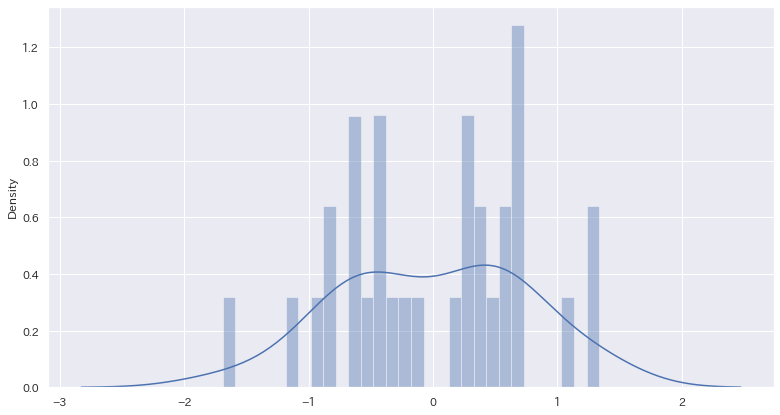

In [34]:
# 回帰分析は残差が正規分布になっていることが望ましいので、プロットして確認
sns.distplot(result.resid,bins=30)
